# Decision Tree Splitting - Visualisation

This code uses a user defined grid to construct a set of simple data. It then finds the best split (as measured by the largest difference between gini impurity scores) and shows it on the graph

In [1]:
import pandas  as pd
import numpy as np
import os # used for checking if files/directories exist

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
x_col = 'Floor Slipperiness'
y_col = 'Shoe Slipperiness'
value_map = {0:'No Fall',1:'Fall'}

# Test data Frame
# Altering this is reflected in the dataframe and the graphs produced, e,g, a 5x5 makes a 25 point graph
# a "1" means it's labelled as a "Fall" and "0" means it's labelled as a "No Fall"
# It assumes datapoints are labelled 0,1,2,3,4 etc. Feel free to add functionality to assign different values!
test = [
[0,1,0,0,0,0,0,0,0],
[1,0,0,0,1,0,0,1,0],
[0,0,0,1,0,0,0,0,0],
[1,0,0,0,0,0,1,0,0],
[1,1,1,1,1,0,0,0,0],
[1,0,1,1,1,0,0,0,0],
[1,1,1,1,1,0,1,0,0],
[1,1,0,1,1,1,0,0,0],
[1,1,1,1,1,1,1,0,1],
[1,1,1,1,1,1,0,0,0]]

# Make the data grid
df = pd.DataFrame(test)

# reset index so the above grip relates to the graph
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)

df.reset_index(inplace=True)
# rename
df.rename({'index':y_col},inplace=True,axis='columns')
df.head(10)

,Shoe Slipperiness,0,1,2,3,4,5,6,7,8
0,0,1,1,1,1,1,1,0,0,0
1,1,1,1,1,1,1,1,1,0,1
2,2,1,1,0,1,1,1,0,0,0
3,3,1,1,1,1,1,0,1,0,0
4,4,1,0,1,1,1,0,0,0,0
5,5,1,1,1,1,1,0,0,0,0
6,6,1,0,0,0,0,0,1,0,0
7,7,0,0,0,1,0,0,0,0,0
8,8,1,0,0,0,1,0,0,1,0
9,9,0,1,0,0,0,0,0,0,0


In [3]:
# Melt it (this turns the grid into a more usable dataframe)
# Have to extract the colums for the x_values while ignoring the column for the Shoe Slipperiness
col_list = list(df.columns)
# remove the y column name from the list (so we get just the x axis values)
col_list.remove(y_col)

df_format = pd.melt(df.reset_index(),id_vars=[y_col],value_vars=col_list)
df_format.rename({'variable':x_col},inplace=True,axis='columns')
# remap the value column
df_format['value']=df_format['value'].map(value_map)

# save it, Uncomment if you want this file (e.g. to put into an Excel file)
# df_format.to_csv('Slip_Data.csv',index=False)

# Display Output
df_format.head(5)

,Shoe Slipperiness,Floor Slipperiness,value
0,0,0,Fall
1,1,0,Fall
2,2,0,Fall
3,3,0,Fall
4,4,0,Fall


In [4]:
def print_data(df_format,x_col,y_col,plot_line=None):
    """
    This takes the dataframe and a set of information to construct the plot
    If a column and value is assigned to "plot_line" then it'll also plot a dotted line horizontally
    or vertically to mark that split
    """
    # remap the marker variables
    map_dict = {'No Fall':'o','Fall':'D'}
    color_dict = {'No Fall':'blue','Fall':'green'}
    size_dict = {'No Fall':150,'Fall':150}

    df_format[x_col] = pd.to_numeric(df_format[x_col])

    first = True
    for group in df_format['value'].unique():
        if first:
            ax = df_format.loc[df_format['value']==group,:].plot.scatter(x=x_col,y=y_col,
                            color=color_dict[group],figsize=(10,10),marker=map_dict[group],
                            s=size_dict[group],label=group)
            first = False
        else:
            df_format.loc[df_format['value']==group,:].plot.scatter(x=x_col,y=y_col,
                                    color=color_dict[group],marker=map_dict[group],ax=ax,s=size_dict[group],label=group)

        plt.title('The Effects of Falls vs. Surfaces',size=30,y=1.05)
    # Check if we need to plot a line
    if plot_line!=None:
        if plot_line[0]==y_col:
            ax.axhline(y=plot_line[1],linestyle='--',label='Best Split Line')
        else:
            ax.axvline(x=plot_line[1],linestyle='--',label='Best Split Line')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
    ax.set_xlabel(x_col,size=25)
    ax.set_ylabel(y_col,size=25)
    plt.show()

In [5]:
def uniquecounts(df,col = 'value'):
    """
    Takes a dataframe and a column and counts the number of time each distinct entry apppears
    in that column before returning it
    """
    temp = df[col].value_counts().reset_index()
    temp.columns = [col,'Counts']
    return temp

In [6]:
# Make the decision code
# Gini Impurity
# The probability that a rondomly placed item will be in the wrong category
def giniimpurity(df,col='value'):
    """
    Calculates the gini impurity score by calculating the probability of selecting an item from a group
    and multiplies it by the probability of it being assigned ot one of the other groups
    This is then repeated and summed to get a total purity
    """
    total=len(df)
    counts = uniquecounts(df,col=col)
    entries = counts[col].unique() # Number of unique entries
    imp=0.0
    for k1 in entries:
        p1 = counts.loc[counts[col]==k1,'Counts'].sum()/total
        for k2 in entries:
            if k1==k2:continue
            p2=counts.loc[counts[col]==k2,'Counts'].sum()/total
            imp+=p1*p2
    return imp

In [7]:
def dividedf(df,column,value):
    """
    This function splits a dataframe based on a column and a value
    If the value is a number it assigns all items greater or equal to it to one group
    and the rest to the second
    If the value is not a number then it assigns all items that exactly match that value to that group
    and the rest goes in the second group
    """
    # We work out if the value is a number or not
    val_type = df[column].tolist()[-1]
    if pd.api.types.is_number(val_type):
        mask = df[column]>=value
    else:
        mask = df[column]==value

    # Split into separate sets
    first_set = df.loc[mask,:].reset_index(drop=True)
    second_set = df.loc[~mask,:].reset_index(drop=True)
    return first_set, second_set

In [8]:
def findbest(df,scorer=giniimpurity,val_col='value'):
    """
    This function takes a dataframe and a way of scoring a split and then iterates over the dataframe
    The output is the best split groups alongside the column and values used to make that split
    """
    col_list = list(df.columns)
    # remove the value column
    col_list.remove(val_col)
    # What's the current score
    current_score = scorer(df,col=val_col)
    print("Initial Score: {}".format(current_score))
    
    # Iterate over the columns
    best_gain = 0.0
    best_criteria=None
    best_column=None
    for col in col_list:
        local_gain = 0.0
        local_column = None
        local_criteria = None
        unique_vals = df.loc[:,col].unique()
        for value in unique_vals:
            # Perform a split at that value
            set1, set2 = dividedf(df,col,value)
            # We weight the change by the fraction of each resulting set (i.e. smaller set has lower contribution)
            set1_fraction = len(set1)/len(df)

            # calculate the gain of impurity
            gain = current_score-set1_fraction*scorer(set1,col=val_col)-(1-set1_fraction)*scorer(set2,col=val_col)

            # Check if there's a gain, also we exclude data where there is no split (i.e. all data in one set)
            if gain>local_gain and len(set1)>0 and len(set2)>0:
                local_gain=gain
                local_column = col
                local_criteria = value
            if gain>best_gain and len(set1)>0 and len(set2)>0:
                best_gain = gain
                best_column = col
                best_criteria = value
                # update criteria to be inbetween
        # To make the graph easier we assign the split as between the two values and not at it for the local best split
        # We will change this back for future builds where we are looking at classes and not continuous numbers
        next_best = df.loc[df[local_column]<local_criteria,local_column].max()
        local_criteria = (local_criteria+next_best)/2
        # Print local best set
        print("For Column {}, best gain was {} for split at {}".format(local_column,round(local_gain,4),local_criteria))
    # Update global best to be between groups for better visualisation on the graphs
    next_best = df.loc[df[best_column]<best_criteria,best_column].max()
    best_criteria = (best_criteria+next_best)/2    
    # Print Overal Best Find
    print("\nBest selection was:")
    print("For Column {}, best gain was {} for split at {}".format(best_column,round(best_gain,4),best_criteria))
    
    # do best cut and return
    set1, set2 = dividedf(df,best_column,best_criteria)
    set1_fraction = len(set1)/len(df)
    set1_score = scorer(set1,col=val_col)
    set2_score = scorer(set2,col=val_col)
    weighted_score = set1_fraction*set1_score-(1-set1_fraction)*set2_score
    print("First Group ({} rows) Score: {} and Second Group ({} rows) Score: {}".format(len(set1),round(set1_score,4),
                                                                                        len(set2),round(set2_score,4)))
    
    return set1, set2, best_column, best_criteria

Initial Score: 0.4960493827160493
For Column Shoe Slipperiness, best gain was 0.0909 for split at 5.5
For Column Floor Slipperiness, best gain was 0.1045 for split at 4.5

Best selection was:
For Column Floor Slipperiness, best gain was 0.1045 for split at 4.5
First Group (40 rows) Score: 0.32 and Second Group (50 rows) Score: 0.4488


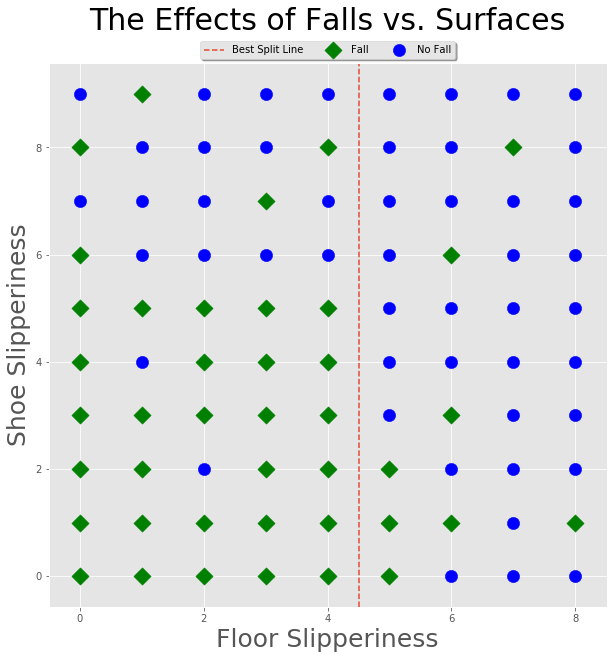

In [9]:
def plot_best_split(df_format,x_col,y_col,col='value'):
    """
    This takes a dataframe, finds the best split and then plots it
    """
    set1,set2,column,value = findbest(df_format)
    print_data(df_format,plot_line=(column,value),x_col=x_col,y_col=y_col)
    
plot_best_split(df_format,x_col=x_col,y_col=y_col)

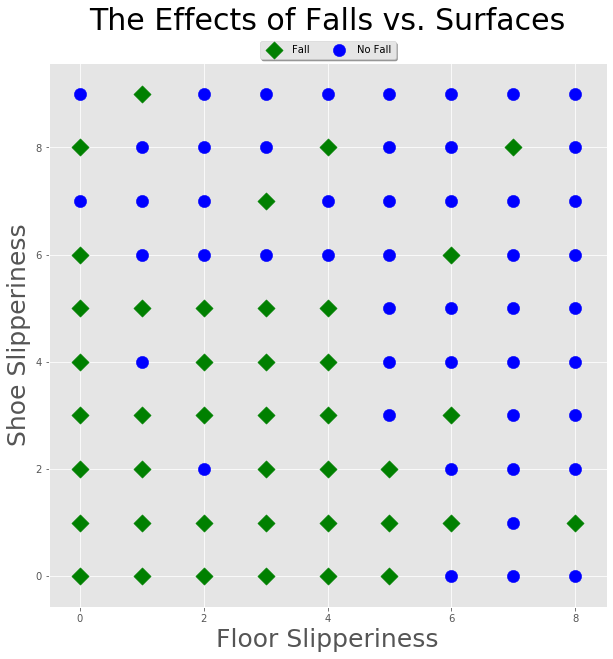

In [10]:
print_data(df_format,x_col=x_col,y_col=y_col)